In [1]:
import pandas as pd
import numpy as np

# Loading  CSV 
PATH = "final_dataset.csv"   
df = pd.read_csv(PATH)

# Make sure emotion labels are lowercase strings
df["initial_emotion"] = df["initial_emotion"].astype(str).str.lower()
df["final_pred_emotion"] = df["final_pred_emotion"].astype(str).str.lower()

# Valence mapping for Ekman emotions
emotion_valence = {
    "anger":   -1,
    "sadness": -1,
    "fear":    -1,
    "disgust": -1,
    "joy":      1,
    "surprise": 0,
    "neutral":  0,
}

def get_valence(emotion):
    """Return valence score for an emotion label."""
    return emotion_valence.get(str(emotion).lower(), 0)

#  Row-wise trajectory computation 
def classify_trajectory(row):
    # valence of initial and final emotions
    init_em = row["initial_emotion"]
    final_em = row["final_pred_emotion"]

    init_val = get_valence(init_em)
    final_val = get_valence(final_em)
    delta_v = final_val - init_val

    # probability change (optional extra info)
    init_p = row.get("initial_prob", np.nan)
    final_p = row.get("final_pred_prob", np.nan)

    prob_change = np.nan
    if not pd.isna(init_p) and not pd.isna(final_p):
        prob_change = final_p - init_p

    # main trajectory label based on valence shift
    if delta_v > 0:
        traj = "improved"
    elif delta_v < 0:
        traj = "worsened"
    else:
        traj = "unchanged"

    return pd.Series({
        "initial_valence": init_val,
        "final_valence": final_val,
        "delta_valence": delta_v,
        "prob_change": prob_change,
        "trajectory": traj,
    })

# apply to every row
traj_df = df.apply(classify_trajectory, axis=1)

# add new columns back to the original dataframe
df = pd.concat([df, traj_df], axis=1)

# Quick summaries
print("Trajectory counts:")
print(df["trajectory"].value_counts())
print("\nMean probability change by trajectory:")
print(df.groupby("trajectory")["prob_change"].mean())

# Save file 
OUTPUT_PATH = "trajectory_results.csv"
df.to_csv(OUTPUT_PATH, index=False)
print(f"\nSaved results with trajectory to: {OUTPUT_PATH}")


Trajectory counts:
trajectory
improved     8793
unchanged    3527
worsened      443
Name: count, dtype: int64

Mean probability change by trajectory:
trajectory
improved     0.224490
unchanged    0.159911
worsened    -0.014629
Name: prob_change, dtype: float64

Saved results with trajectory to: trajectory_results.csv


In [1]:
import pandas as pd

# file path
TRAJ_FILE = "trajectory_results.csv"

traj_df = pd.read_csv(TRAJ_FILE)
print("Columns:", traj_df.columns.tolist())
traj_df.head()


Columns: ['forum_name', 'thread_id', 'post_content', 'Cohort', 'initial_emotion', 'initial_prob', 'final_pred_emotion', 'final_pred_prob', 'initial_valence', 'final_valence', 'delta_valence', 'prob_change', 'trajectory']


,forum_name,thread_id,post_content,Cohort,initial_emotion,initial_prob,final_pred_emotion,final_pred_prob,initial_valence,final_valence,delta_valence,prob_change,trajectory
0,anxiety,610659,hi my name is michelle and i have had anxiety ...,B,fear,0.341005,joy,0.928310,-1,1,2,0.587305,improved
1,anxiety,611578,i ve never written on a forum like this before...,B,fear,0.625716,joy,0.890014,-1,1,2,0.264298,improved
2,anxiety,611573,i am international student to tasmania in 2021...,B,sadness,0.547605,joy,0.790593,-1,1,2,0.242988,improved
3,anxiety,611587,"hello, i struggle with feeling very home sick ...",B,fear,0.416352,joy,0.944687,-1,1,2,0.528335,improved
4,anxiety,180185,and it was entirely my own fault. i tried cros...,B,sadness,0.882927,joy,0.706641,-1,1,2,-0.176286,improved


In [6]:
print(traj_df["trajectory"].unique())


['improved' 'unchanged' 'worsened']


Trajectory counts:
trajectory
improved     8793
unchanged    3527
worsened      443
Name: count, dtype: int64


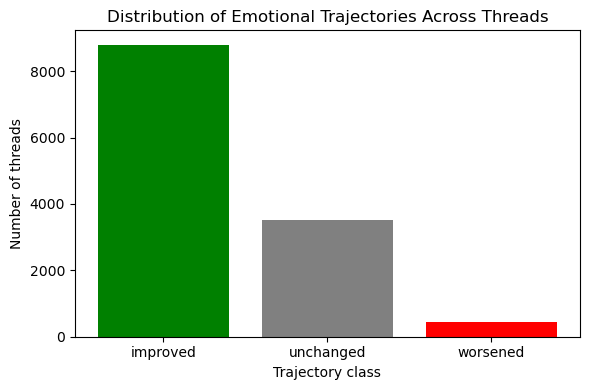

In [7]:
# Emotional trajectory distribution

import matplotlib.pyplot as plt

order = ["improved", "unchanged", "worsened"]
traj_counts = traj_df["trajectory"].value_counts().reindex(order, fill_value=0)

print("Trajectory counts:")
print(traj_counts)

plt.figure(figsize=(6, 4))
plt.bar(traj_counts.index, traj_counts.values, color=["green", "grey", "red"])
plt.xlabel("Trajectory class")
plt.ylabel("Number of threads")
plt.title("Distribution of Emotional Trajectories Across Threads")
plt.tight_layout()
plt.show()


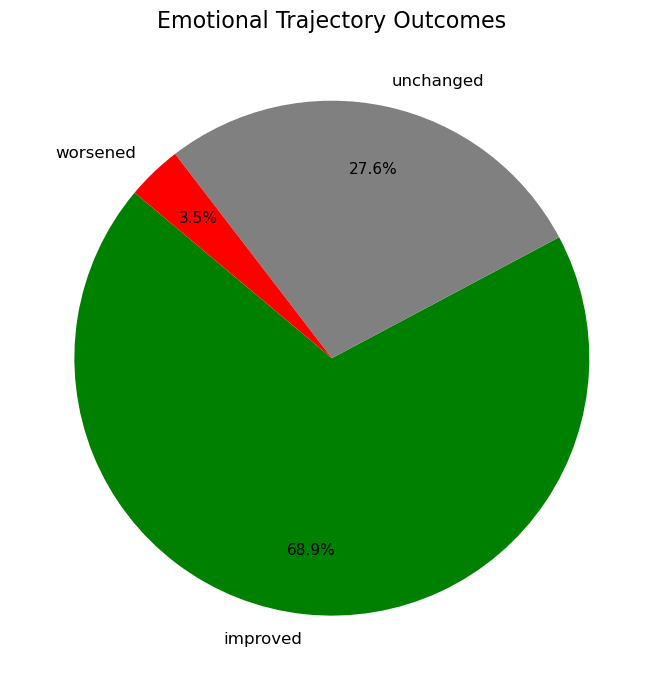

In [8]:
# Pie Chart for Emotional Trajectories 

counts_nonzero = traj_counts[traj_counts > 0]

plt.figure(figsize=(7,7))
wedges, texts, autotexts = plt.pie(
    counts_nonzero.values,
    labels=counts_nonzero.index,
    autopct="%1.1f%%",
    startangle=140,
    pctdistance=0.75,
    labeldistance=1.1,
    colors=["green", "grey", "red"]
)

for t in texts: t.set_fontsize(12)
for t in autotexts: t.set_fontsize(11)

plt.title("Emotional Trajectory Outcomes", fontsize=16)
plt.tight_layout()
plt.show()


Mean probability change per trajectory:
trajectory
improved     0.224490
unchanged    0.159911
worsened    -0.014629
Name: prob_change, dtype: float64


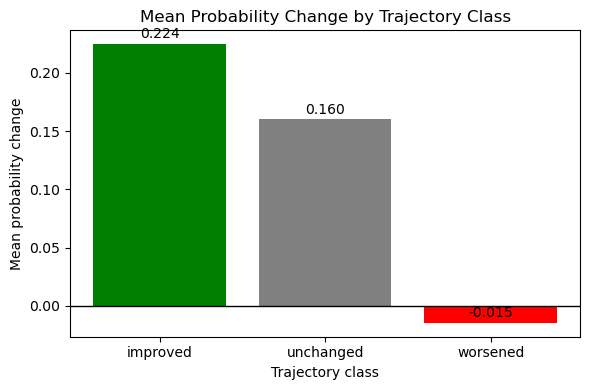

In [9]:
# Mean probability change by trajectory class 

import matplotlib.pyplot as plt

mean_prob = (
    traj_df.groupby("trajectory")["prob_change"]
    .mean()
    .reindex(order)
)

print("Mean probability change per trajectory:")
print(mean_prob)

plt.figure(figsize=(6,4))
bars = plt.bar(mean_prob.index, mean_prob.values, color=["green","grey","red"])
plt.axhline(0, color="black", linewidth=1)

plt.xlabel("Trajectory class")
plt.ylabel("Mean probability change")
plt.title("Mean Probability Change by Trajectory Class")

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.005,
        f"{height:.3f}",
        ha="center",
        fontsize=10
    )

plt.tight_layout()
plt.show()


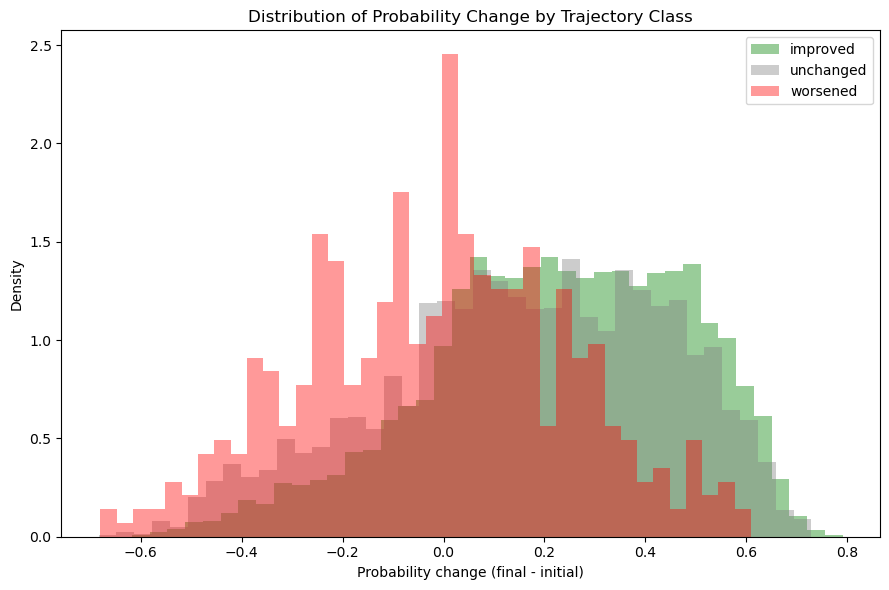

In [11]:
# Probability change distribution per trajectory

plt.figure(figsize=(9,6))

colors = {"improved":"green", "unchanged":"grey", "worsened":"red"}

for traj in order:
    subset = traj_df[traj_df["trajectory"] == traj]["prob_change"]
    plt.hist(
        subset,
        bins=40,
        alpha=0.4,
        label=traj,
        density=True,
        color=colors[traj]
    )

plt.xlabel("Probability change (final - initial)")
plt.ylabel("Density")
plt.title("Distribution of Probability Change by Trajectory Class")
plt.legend()
plt.tight_layout()
plt.show()
